In [1]:
import sys
sys.path.append('/home/hiwi/Desktop/msa')

# Imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# ---------
from msapy import msa, utils as ut, plottings as pl
# ---------
from functools import partial

CM = 1 / 2.54
SEED = 42
RNG = np.random.default_rng(SEED)
FIGPATH = "figures/gt/"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torchvision import datasets

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [4]:
mnist_transforms = T.Compose([T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = mnist_transforms, 
    download = True,            
)

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = mnist_transforms
)

In [5]:
trainloader = DataLoader(train_data, 
                        batch_size=64, 
                        shuffle=True)
    
testloader = DataLoader(test_data, 
                        batch_size=1024)

In [6]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 32)
        self.layer2 = nn.Sequential(nn.LeakyReLU(),
                                nn.Linear(32, 10))

    def forward(self, x, lesion_idx = None):
        out = self.layer1(x)

        if lesion_idx:
            out[:, lesion_idx] = 0

        return self.layer2(out)

model = MNISTNet().to(device)

In [7]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 400:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   400] loss: 0.353
[1,   800] loss: 0.208
[2,   400] loss: 0.163
[2,   800] loss: 0.160
Finished Training


In [9]:
@torch.no_grad()
def test_accuracy(lesion_idx=None, num_batches=-1):
    correct = 0
    total = 0

    for i, data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images, lesion_idx)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i==(num_batches-1):
            return (correct/total)*100
    
    return (correct/total)*100

In [14]:
test_accuracy(num_batches=1)

95.1171875

In [11]:
ground_truth_elements = list(range(32)) # our brain regions, for example!
print(f'total number of possible lesions: {2**len(ground_truth_elements)}')

total number of possible lesions: 4294967296


In [12]:
shapley_table, _, _ = msa.interface(
    elements=ground_truth_elements,
    n_permutations=1000,
    objective_function=partial(test_accuracy, num_batches=1),
    n_parallel_games=-1, #parallelized over all CPU cores
    rng=RNG)

Playing the games: 100%|██████████| 27682/27682 [13:01<00:00, 35.41it/s]


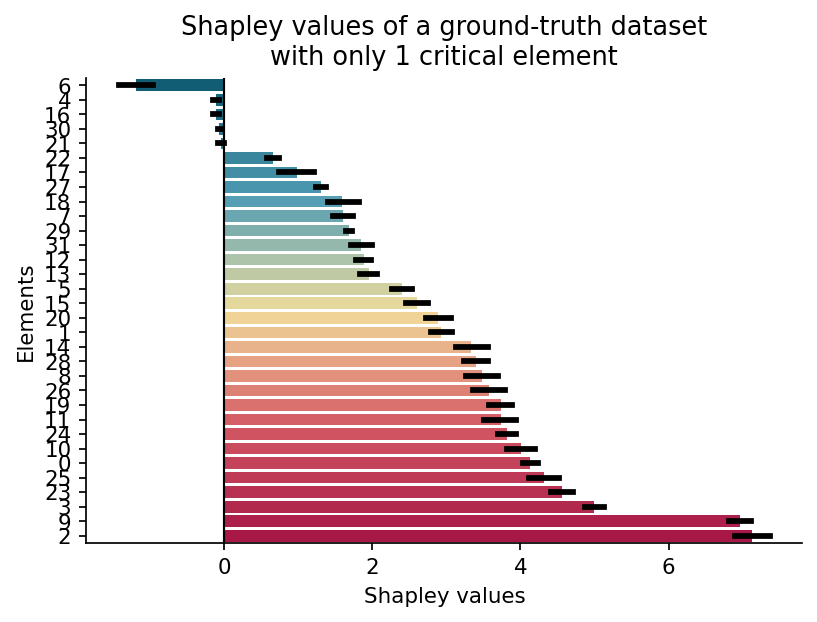

In [13]:
shapley_table = ut.sorter(shapley_table) # sorting based on the average contribution (Shapley values)

fig,ax = plt.subplots()
colors = pl.color_code(shapley_table=shapley_table)
pl.plot_shapley_ranks(shapley_table=shapley_table,colors=colors,ax=ax)
fig.set_dpi(154)
plt.xlabel('Shapley values')
plt.ylabel('Elements')
plt.title('Shapley values of a ground-truth dataset\nwith only 1 critical element')
plt.savefig(f"{FIGPATH}1critical.pdf",dpi=300,bbox_inches='tight')